# <font color="blue">Part II: Cluster Number Selection</font>

 - Visual methods: Elbow Criterion
 - Mathematical methods: Segment Analysis

# Import Modules

In [6]:
# Data Manipulation Libraries: Standard dataframes and array libraries
import pandas as pd
import numpy as np
from pandas import ExcelWriter
from pandas import ExcelFile
# from datetime import datetime
import datetime as dt

# Data Visualization Libraries:
import matplotlib.pyplot as plt
import seaborn as sns

# K-means clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Displaying plots in jupter notebook
%matplotlib inline
# Displaying pandas columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Import data
%store -r rfm_data
%store -r dataset_log
%store -r df_normalized

# Elbow Criterion Method

 - Plot the number of clusters against within-cluster sum-of-squared-erros (SSE)- sum of squared distances from every data point to their cluster center
 - The 'Elbow' represents an 'optimal' number of clusters

In [35]:
# Create an empty dictionary
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_normalized)
    sse[k] = kmeans.inertia_

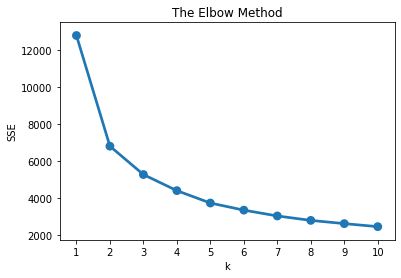

In [36]:
# Plot SSE for each k 'cluster'
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font><br>
Criteria points to 2 clusters as the solutions
</div>

# Experimental Approach - Analyze Segments

 - Build clustering at and around elbow solution
 - Analyze average RFM values
 - Compare against other solutions and identify which provides most insight

In [37]:
kmeans3 = KMeans(n_clusters=3, random_state=1)
# compute k-means clustering on pre-processed data
kmeans3.fit(df_normalized)
# Extract cluster labels using <code>labels_</code> attribute
cluster_labels = kmeans3.labels_
rfm_dataset_cluster3 = rfm_data.assign(Cluster = cluster_labels)
rfm_dataset_cluster3.groupby(["Cluster"]).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Value': ["mean", 'count']
}).round(0)

Recency Frequency Monetary Value      
           mean      mean           mean count
Cluster                                       
0          13.0     257.0         6398.0   943
1         160.0      15.0          288.0  1491
2          67.0      65.0         1167.0  1830

<div style="border:1px solid black; padding:10px">
<font color="blue">Note:</font>
    <ul>
        <li>In this example, there are three clusters that are defined by ther mean recency, frequency, and amount they have spent.</li>
        <li>The monetary count provides the number of purchases.</li>
        <li>Customers in cluster 0 have made recent purchases, make more visits, and spend more per transaction.</li>
        <li>Customers in cluster 1 have not made recent purchases, dont make that many visits, and spend less per transaction than customers in cluster 0 and 2.</li>
        <li>Customers in cluster 2 are customers whose profiles are between cluster 0 and 1.
    </ul>
    
</div>

### Profile and Interpret Segments

Approaches to build customer personas
 - Summary statistics for each cluster
 - Snake plots
 - Calculate relative importance of cluster attributes compared to population

### Snake plots
 - Market research technique to compare different segments
 - Visual representation of each segment's attributes
 - Need to first normalize data (center and scale)
 - Plot each clusters average normalized values of each attribute

In [38]:
df_normalized['Cluster'] = rfm_dataset_cluster3['Cluster']

In [39]:
df_normalized.replace({'Cluster': {0: 'One', 1: 'Two', 2:'Three'}}, inplace=True)

In [41]:
df_melt = pd.melt(df_normalized.reset_index(),
                 id_vars=['CustomerID', 'Cluster'],
                 value_vars = ['Recency', 'Frequency', 'Monetary Value'],
                  var_name='Attribute',
                  value_name='Value'
                 )

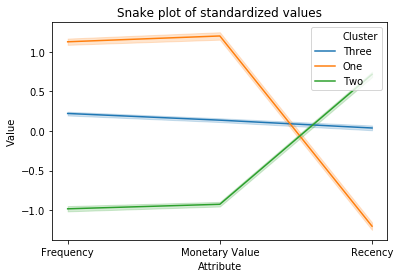

In [42]:
plt.title('Snake plot of standardized values')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_melt)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()

### Relative importance of segment attributes
 - identify relative importance of each segment's attribute
 - calculate average values of each cluster
 - calculate average values of population

In [43]:
cluster_avg = rfm_dataset_cluster3.groupby(['Cluster']).mean()
population_avg = rfm_data.mean()

In [44]:
relative_imp = cluster_avg/population_avg - 1

### Analyze and plot relative importance

 - further ratio is from 0, the more important that attribute is for a segment, relative to the total population

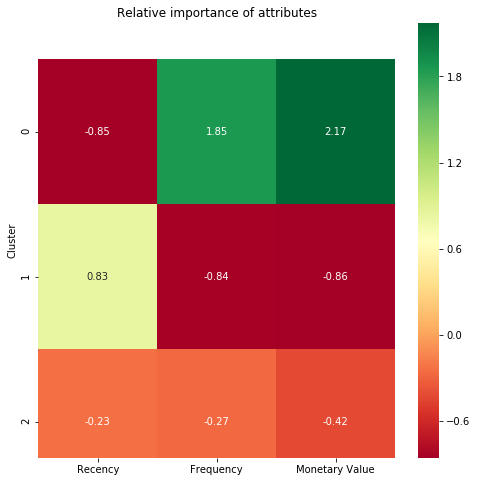

In [45]:
plt.figure(figsize=(8,8))
plt.title('Relative importance of attributes')
chart = sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
# Makes sure the plot is visible
chart.set_ylim(len(relative_imp)-0.25, -0.25)
# plt.savefig("filepath/filename.format", bbox_inches='tight')
plt.show()